# Assignment 5

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [2]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
# original: clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = [[] for i in range(num_epochs)]


enumerate_kfold = list(enumerate(kfold))
# new:
clfs = [Perceptron(random_state=1) for i in range(len(enumerate_kfold))]

for epoch in range(num_epochs):
    for k, (train, test) in enumerate_kfold:
        
# original:
#         clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))
#         score = clf.score(X_train_std[test], y_train[test])
#         scores.append(score)
# new:
        clfs[k].partial_fit(X_train_pca[train], y_train[train], classes=np.unique(y_train))
        score = clfs[k].score(X_train_pca[test], y_train[test])
        scores[epoch].append(score)
        
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')

# new:
for epoch in range(num_epochs):
    print('Epoch: %s, CV accuracy: %.3f +/- %.3f' % (epoch, np.mean(scores[epoch]), np.std(scores[epoch])))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.957
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.957
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.913
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 0.956
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.956
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.913
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.956
Epoch: 1, Fold: 8, Class di

## Answer
#### Problems with the original code:
1. Use partial fit for all folds, which results in dependent training and thus cumulative learning.<br>
2. Due to problem 1, we the CV accuracy is incorrect, and not able to show score for every epoch. <br>

#### There are two major changes:
1. We create a list of Perceptrons, each corresponds to one fold. Within each fold, we run partial fit for a given number of epochs. <br>
2. Also, we create a list of accuracy scores, each corresponds to one epoch. Within each epoch, we append scores of all folds. <br>

#### There is one minor change:
1. To enable PCA, we change X_train_std into X_train_pca.<br>

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

ROC Curve - 2 Features


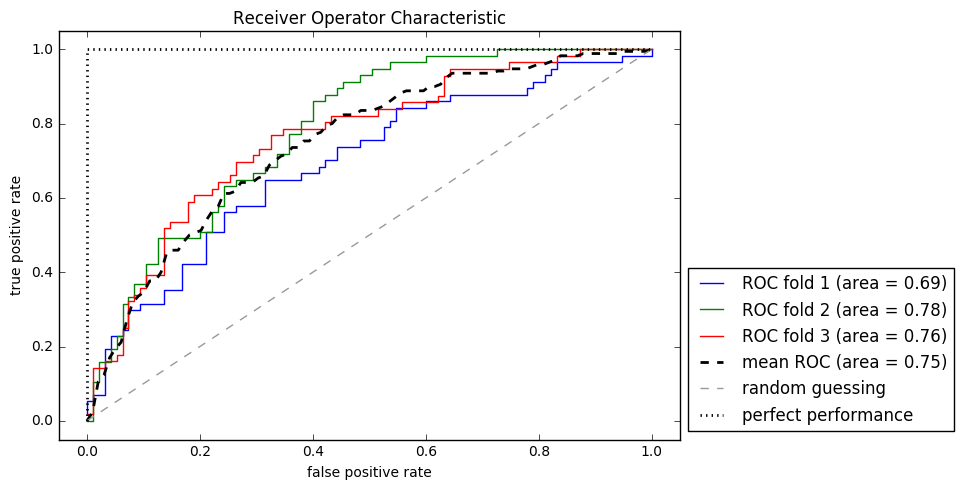

ROC Curve - All Features


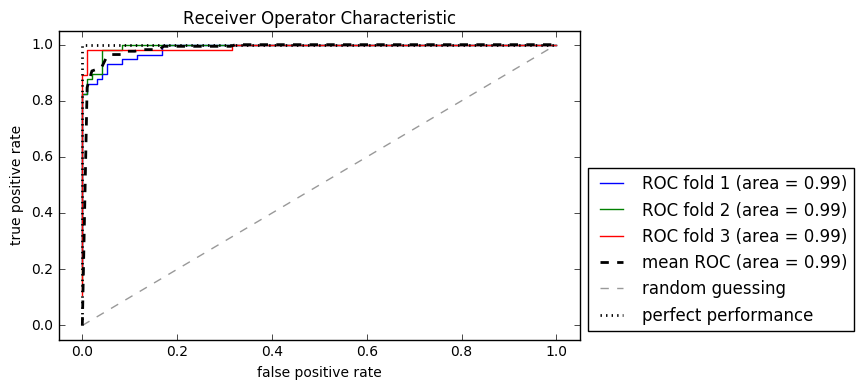

Precision Recall Curve - 2 Features


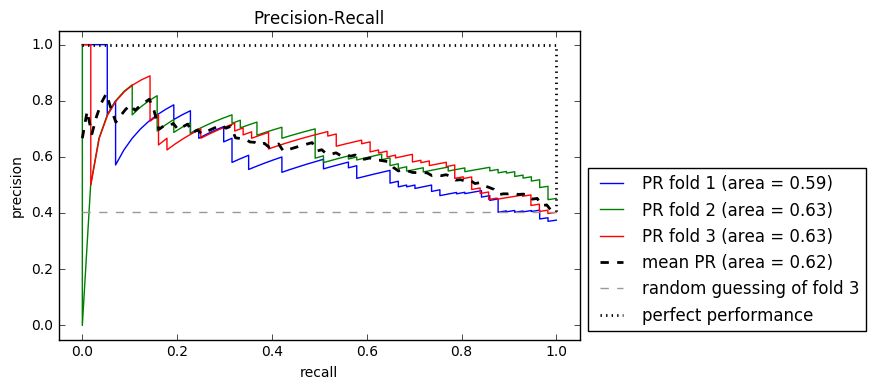

Precision Recall Curve - All Features


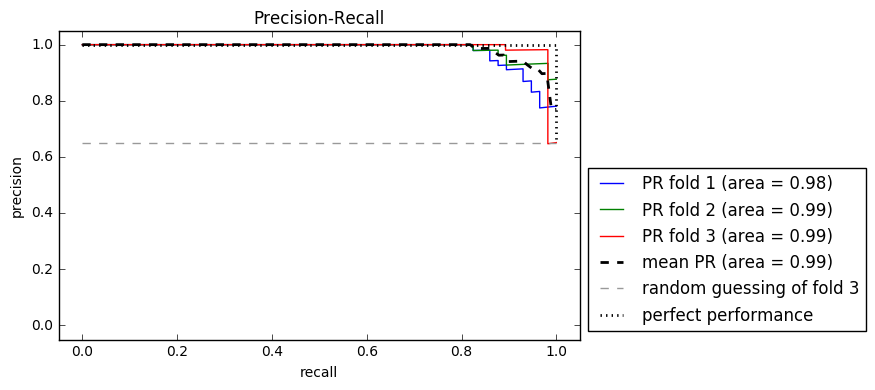

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from scipy import interp
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]


if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
else:
    cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

# **************************************
#            ROC - 2 Features
# **************************************
print ("ROC Curve - 2 Features")
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    #mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

# **************************************
#            ROC - All Features
# **************************************
print ("ROC Curve - All Features")
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    #mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()


# **************************************
#      Precision-Recall - 2 Features
# **************************************
print ("Precision Recall Curve - 2 Features")
mean_pre = 0.0
mean_rec = np.linspace(0, 1, 100)
all_pre = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    
    ## note that the return order is precision, recall
    pre, rec, thresholds = precision_recall_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    
    ## flip the recall and precison array
    mean_pre += interp(mean_rec, np.flipud(rec), np.flipud(pre))

    pr_auc = auc(rec, pre)
    plt.plot(rec,
             pre,
             lw=1,
             label='PR fold %d (area = %0.2f)'
                   % (i+1, pr_auc))

mean_pre /= len(cv)
mean_auc = auc(mean_rec, mean_pre)
plt.plot(mean_rec, mean_pre, 'k--',
         label='mean PR (area = %0.2f)' % mean_auc, lw=2)

# random classifier: a line of Positive/(Positive+Negative)
# here for simplicity, we set it to be Positive/(Positive+Negative) of fold 3
plt.plot(mean_rec,
         [pre[0] for i in range(len(mean_rec))],
         linestyle='--', label='random guessing of fold 3', color=(0.6, 0.6, 0.6))

# perfect performance: y = 1 for x in [0, 1]; when x = 1; down to the random guessing line
plt.plot([0, 1, 1],
         [1, 1, pre[0]],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

# **************************************
#    Precision-Recall - All Features
# **************************************
print ("Precision Recall Curve - All Features")
mean_pre = 0.0
mean_rec = np.linspace(0, 1, 100)
all_pre = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])
    
    
    ## note that the return order is precision, recall
    pre, rec, thresholds = precision_recall_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    
    ## flip the recall and precison array
    mean_pre += interp(mean_rec, np.flipud(rec), np.flipud(pre))

    pr_auc = auc(rec, pre)
    plt.plot(rec,
             pre,
             lw=1,
             label='PR fold %d (area = %0.2f)'
                   % (i+1, pr_auc))

mean_pre /= len(cv)
mean_auc = auc(mean_rec, mean_pre)
plt.plot(mean_rec, mean_pre, 'k--',
         label='mean PR (area = %0.2f)' % mean_auc, lw=2)

# random classifier: a line of Positive/(Positive+Negative)
# here for simplicity, we set it to be Positive/(Positive+Negative) of fold 3
plt.plot(mean_rec,
         [pre[0] for i in range(len(mean_rec))],
         linestyle='--', label='random guessing of fold 3', color=(0.6, 0.6, 0.6))

# perfect performance: y = 1 for x in [0, 1]; when x = 1; down to the random guessing line
plt.plot([0, 1, 1],
         [1, 1, pre[0]],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

## Explanation

### Definition
REC(recall) = TPR(true positive rate) = $\frac{TP}{TP+FN}$<br>
PRE(precision) = $\frac{TP}{TP+FP}$<br>
FPR(false positive rate) = $\frac{FP}{FP+TN}$<br>
TP: Actual Class $A$, test result $A$<br>
FP: Actual Class $B$, test result $A$<br>
TN: Actual Class $B$, test result $B$<br>
FN: Actual Class $A$, test result $B$<br>

### Similarities
1. When number of features increases, in ROC curve, true positive rate is close to 1 regardless of false positive rate (not equals 0); in Precison-Recall curve, precision is close to 1 regardless of recall (not equals 1).<br>
2. The training results are better than random guessing in this example.<br>

### Differences

#### For monotonicity
* ROC curve: As false positive rate increase, the true positive rate generally increases, and the effect is huger when number of features is small.<br>
This is because when avoid classifying class $B$ as class $A$, we actually increase the probability of successfully classifying class $A$ as class $A$, which increases the true positive rate.<br>
Actually, the curve is almost concave. The image below illustrates the reason.
<img src="https://github.com/irsisyphus/Pictures/raw/master/ML-Exercises/roc.png"><br>
Please keep online to view the picture. Reference: https://upload.wikimedia.org/wikipedia/commons/5/5c/ROCfig.PNG<br><br>
* Precision-Recall curve: As recall increases, the precision generally decreases, especially when number of features is small.<br>
This is because when we try to increase recall (reduce false negative), we avoid classifying samples with acutal class $A$ as class $B$, that is, we classify samples similar to class $A$ as class $A$. However, whis will also increase the probability of classifying samples with acutal class $B$ (but tested to be similar to class $A$) as class $A$, which is FP.<br>
Notice that when FP increases, it is _not necessary_ that precision decrease since TP also increases. Only when the ratio $\frac{TP}{TP+FP}$ drops, which is often the general case when number of features is small, precision drops. The image below illustrates the reason.
<img width=50% src="https://github.com/irsisyphus/Pictures/raw/master/ML-Exercises/pre-rec.png"><br>
Please keep online to view the picture. Reference: http://numerical.recipes/CS395T/lectures2008/17-ROCPrecisionRecall.pdf

#### For random guessing
* ROC curve: true positive rate = false positive rate. This is because the propotion of TP in (TP+FN) equals the propotion of FP in (FP+TN), because declaring a result has no dependence on the actuall class label for random guessing.
* Precision-Recall curve: the random guessing is a horizontal line with y = P/(P+N) for given boundary of P and N, which varies with cases. (In this example, we choose P/(P+N) of fold 3 for simplicity).

#### For perfect performance
* ROC curve: The perfect performance is (0, 0) -> (0, 1) -> (1, 1). We aim to have result in the "top-left" corner to obtain low false positive rate and high true positive rate.
* Precision-Recall curve: The perfect performance is (0, 1) -> (1, 1) -> (1, P/(P+N)). We aim to have result in the "top-right" corner to obtain high recall and high precision.

# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [8]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [11]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [12]:
print(ensemble_error(num_classifier=num_classifier, base_error=base_error))

0.034327507019


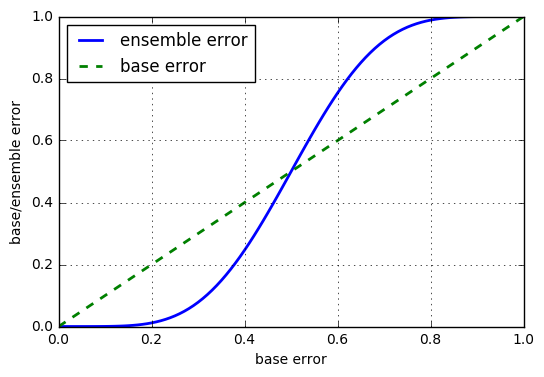

In [13]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [14]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):

    num_classifiers = range(1, max_num_classifier+1)
    ensemble_errors = [ensemble_error_func(num_classifier = num_classifier, base_error=base_error) for num_classifier in num_classifiers]

    plt.plot(num_classifiers, ensemble_errors, 
             label = 'ensemble error',
             linewidth = 2)
    plt.plot(range(max_num_classifier), [base_error]*max_num_classifier,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    
    plt.xlabel('num classifiers')
    plt.ylabel('ensemble error')
    plt.xlim([1, max_num_classifier])
    plt.ylim([0, 1])
    plt.title('base error %.2f' % base_error)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [15]:
max_num_classifiers = 20
base_error = 0.25

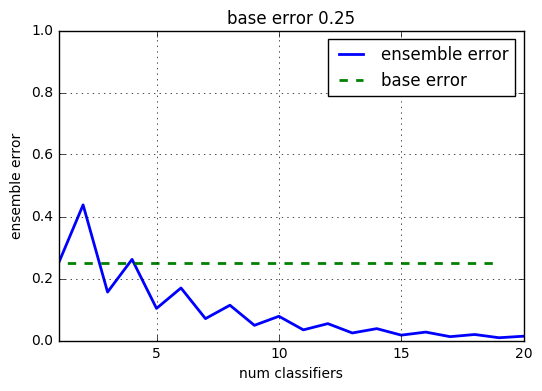

In [16]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

### Explanation
#### Observations:
The ensemble error __DOES NOT ALWAYS__ go down with more classifiers.<br>
Overall, the ensemble error declines as the number of classifiers increases. However, when the number of calssifiers $N = 2k$, the error is much higher than $N = 2k-1$ and $2k+1$.
#### Reason:
This is because when a draw comes, i.e. $K$ subclassifiers are wrong and $K$ subclassifiers are correct, it is considered as "wrong prediction" by the original function.

Describe a better algorithm for computing the ensemble error.

In [17]:
def better_ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    if num_classifier % 2 == 0:
        probs.append(-0.5*comb(num_classifier, k_start)*(base_error**k_start)*((1-base_error)**(num_classifier-k_start)))
    return sum(probs)

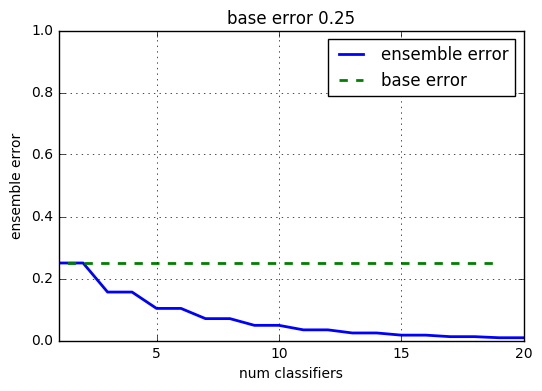

In [18]:
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

### Discription
When there is a draw, i.e. $K$ subclassifiers are wrong and $K$ subclassifiers are correct, we take half of the probability of this condition to be wrong. That is, $\frac{1}{2} C\left(2K, K\right) \epsilon^K \left(1-\epsilon\right)^{K}$.<br>
Notice that the result of $2K$ classifiers is the same as $2K-1$ classifier, Becase<br><br>
$$
\begin{align}
P(2K\text{ failed}) = & \text{ }P(2K\text{ failed | }K\text{ in }2K-1\text{ failed})P(K\text{ in }2K-1\text{ failed}) \\
& + P(2K\text{ failed | }K-1\text{ in }2K-1\text{ failed})P(K-1\text{ in }2K-1\text{ failed}) \\
& + P(2K\text{ failed | less than }K-1\text{ in }2K-1\text{ failed})P(\text{less than }K-1\text{ in }2K-1\text{ failed}) \\
& + P(2K\text{ failed | more than }K\text{ in }2K-1\text{ failed})P(\text{more than }K\text{ in }2K-1\text{ failed}) \\
= & \text{ }(\epsilon + \frac{1-\epsilon}{2})C\left(2K-1, K\right)\epsilon^K \left(1-\epsilon\right)^{K-1}
+ (\frac{\epsilon}{2})C\left(2K-1, K-1\right)\epsilon^{K-1} \left(1-\epsilon\right)^{K} \\
& + 0 \times \sum_{i=0}^{K-2}C\left(2K-1, i\right)\epsilon^i \left(1-\epsilon\right)^{2K-1-i}
+ 1 \times \sum_{i=K+1}^{2K-1}C\left(2K-1, i\right)\epsilon^i \left(1-\epsilon\right)^{2K-1-i} \\
= & \text{ }C\left(2K-1, K\right)\epsilon^{K+1} \left(1-\epsilon\right)^{K-1} + C\left(2K-1, K\right)\epsilon^K \left(1-\epsilon\right)^{K} + \sum_{i=K+1}^{2K-1}C\left(2K-1, i\right)\epsilon^i \left(1-\epsilon\right)^{2K-1-i} \\
= & \text{ }C\left(2K-1, K\right) (\epsilon + 1 - \epsilon) \epsilon^{K} \left(1-\epsilon\right)^{K-1} + \sum_{i=K+1}^{2K-1}C\left(2K-1, i\right)\epsilon^i \left(1-\epsilon\right)^{2K-1-i} \\
= & \text{ }\sum_{i=K}^{2K-1}C\left(2K-1, i\right)\epsilon^i \left(1-\epsilon\right)^{2K-1-i} \\
= & \text{ }P(2K-1\text{ failed})
\end{align}
$$<br>
Hence $P(2K$ failed) = $P(2K-1$ failed).